In [1]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

In [2]:
def load_data():
    data = pd.read_pickle('../../data/dataframes/data.pkl')
    nomination_onehot = pd.read_pickle('../../data/dataframes/nomination_onehot.pkl')
    selected_performers_onehot = pd.read_pickle('../../data/dataframes/selected_performers_onehot.pkl')
    selected_directors_onehot = pd.read_pickle('../../data/dataframes/selected_directors_onehot.pkl')
    selected_studio_onehot = pd.read_pickle('../../data/dataframes/selected_studio_onehot.pkl')
    selected_scriptwriter_onehot = pd.read_pickle('../../data/dataframes/selected_scriptwriter_onehot.pkl')
    review_dataframe = pd.read_pickle('../../data/dataframes/review_dataframe.pkl')
#     tf_idf = pd.read_pickle('../../data/dataframes/tfidf.pkl')
#     lda_topics = pd.read_pickle('../eigacom_review/topics.pkl')

    
    # selected_directors_onehotとselected_scriptwriter_onehotの重複した人
    duplicate_scriptwriter = set(selected_directors_onehot.columns) & set(selected_scriptwriter_onehot.columns)
    selected_scriptwriter_onehot = selected_scriptwriter_onehot.drop(duplicate_scriptwriter, axis=1)
    
    frames = [nomination_onehot,selected_performers_onehot,selected_directors_onehot,selected_studio_onehot,selected_scriptwriter_onehot,]

    df = data
    for f in frames:
        df = pd.merge(df, f, on='id')
    
    drop_elements = ["director", "other_nominates", "performers", "production_studio", "scriptwriter", "title",  'selected_performers', 'selected_directors', 'selected_studio',
       'selected_scriptwriter']
    df_drop = df.drop(drop_elements, axis=1)

    return df_drop, data

In [3]:
df_drop, data = load_data()

In [5]:
data

,director,other_nominates,performers,prize,production_studio,screen_time,scriptwriter,title,year,selected_performers,selected_directors,selected_studio,selected_scriptwriter
id,,,,,,,,,,,,,
1,[山田洋次],"[hochi_eigashou, blue_ribbon_award]","[高倉健, 倍賞千恵子, 桃井かおり, 武田鉄矢, 渥美清]",1,[松竹],108,"[山田洋次, 朝間義隆]",幸福の黄色いハンカチ,1978,[高倉健],[山田洋次],[松竹],"[山田洋次, 朝間義隆]"
2,"[浦山桐郎, 橋本幸治]",[],"[田中健, 大竹しのぶ, いしだあゆみ, 高橋悦史, 伊東辰夫, 高瀬春奈, 高山彰, 梅宮...",0,[東宝],161,"[早坂暁, 浦山桐郎]",青春の門 自立篇（1977）,1978,[大竹しのぶ],[],[東宝],[早坂暁]
3,"[新藤兼人, 小松崎和男]",[],"[高橋竹山, 林隆三, 乙羽信子, 金井大, 倍賞美津子, 島村佳江, 観世栄夫, 根岸明美...",0,[独立映画センター],125,[新藤兼人],竹山ひとり旅,1978,[倍賞美津子],[],[],[新藤兼人]
4,"[森谷司郎, 神山征二郎]",[],"[島田正吾, 大滝秀治, 高倉健, 丹波哲郎, 藤岡琢也, 浜田晃, 加藤健一, 江幡連, ...",0,[東宝],169,[橋本忍],八甲田山,1978,"[大滝秀治, 緒形拳, 神山繁, 高倉健, 丹波哲郎]",[神山征二郎],[東宝],[]
5,"[篠田正浩, 永井正夫]",[],"[岩下志麻, 原田芳雄, 奈良岡朋子, 神保共子, 横山リエ, 宮沢亜古, 中村恵子, 殿山...",0,[東宝],117,"[長谷部慶治, 篠田正浩]",はなれ瞽女おりん,1978,"[西田敏行, 樹木希林, 浜村純]",[篠田正浩],[東宝],[]
6,"[野村芳太郎, 大嶺俊順]",[mainichi_film_award],"[永島敏行, 松坂慶子, 大竹しのぶ, 佐分利信, 中野誠也, 磯部勉, 芦田伸介, 丹波哲...",1,[松竹],138,[新藤兼人],事件,1979,"[永島敏行, 丹波哲郎, 大竹しのぶ]",[],[松竹],[新藤兼人]
7,[大島渚],[],"[長谷川真砂美, 伊佐山ひろ子, 佐藤慶, 殿山泰司, 田村高廣, 吉行和子, 藤竜也, 杉...",0,[],108,[],愛の亡霊,1979,"[田村高廣, 吉行和子]",[],[],[]
8,"[野村芳太郎, 松原信吾]",[],"[岩下志麻, 緒形拳, 岩瀬浩規, 吉沢美幸, 石井旬, 蟹江敬三, 穂積隆信, 大滝秀治,...",0,[松竹],110,[井手雅人],鬼畜,1979,"[大滝秀治, 緒形拳, 大竹しのぶ, 浜村純, 田中邦衛]",[],[松竹],[]
9,"[東陽一, 青池憲司]","[hochi_eigashou, blue_ribbon_award, kinejun_be...","[永島敏行, 吉田次昭, 森下愛子, 志方亜紀子, 島倉千代子, 内藤武敏, 峰岸徹, 片桐...",0,[ATG],103,[寺山修司],サード,1979,[永島敏行],[],[],[]


In [37]:
def standard(x_train, x_test):
    stdsc = StandardScaler()

    # 訓練用のデータを標準化
    x_train_std = stdsc.fit_transform(x_train)
    # 訓練用データを基準にテストデータも標準化
    x_test_std = stdsc.transform(x_test)
    
    return x_train_std, x_test_std

In [38]:
# 多重共線性の排除 (共分散0.7以上のfeatureを削除)

def collinearity(X):

    # 改善前
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.70,vmax=1,cmap=plt.cm.Spectral_r)

    # 改善
    drop_clm = ['吉田一夫']
    X = X.drop(drop_clm,  axis=1)

    # 改善後
    
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.80,vmax=1,cmap=plt.cm.Spectral_r)
    
    return X

In [39]:
def data_processing(test_year):
    df, data = load_data()
    
    df = collinearity(df)
    
    train = df.loc[df["year"] != test_year]
    test = df.loc[df["year"] == test_year]
    
    # 入力データの作成
    y_train = train['prize'].ravel()
    x_train = train.drop(['prize', 'year'], axis=1)
    
    features = x_train.columns
    
    x_train = x_train.values # 学習データ
    
    # テストデータの作成
    y_test = test['prize'].ravel()
    x_test = test.drop(['prize', 'year'], axis=1)
    x_test = x_test.values # テストデータ

    # データの標準化
    x_train_std, x_test_std = standard(x_train, x_test)
    
    return x_train_std, x_test_std, y_train, y_test, features

In [40]:
def print_weight_map(weight, features):
    # feature importance
    feature_imp = weight.reshape(features.shape)
    feature_imp_arg = np.argsort(feature_imp)
    f_num = len(feature_imp_arg)
    plt.rcParams["font.family"] = "IPAexGothic"
    plt.figure(figsize=(20,20))
    plt.barh(range(len(feature_imp_arg)), feature_imp[feature_imp_arg], color='b', align='center')
    plt.yticks(range(len(feature_imp_arg)), features[feature_imp_arg])
    plt.show()

In [41]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [42]:
# optunaで最適なC_valを探す

def train():
    
    th_prob = 0.5
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = data_processing(y)
        
        # 学習
        lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001) # ロジスティック回帰モデルのインスタンスを作成
        lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
        
        # 予測(確率)
        probs = lr.predict_proba(x_test_std)
        probs_all = np.hstack((probs_all, probs[:,1]))
        y_true_all = np.hstack((y_true_all, y_test))

        # 混同行列
        y_pred = np.where((probs[:,1] ==  max(probs[:,1])) | (probs[:,1] > th_prob), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
        
       # 各特徴量の重み係数
        weight = lr.coef_
        
        
        # uncomment to show the weight map
#         print_weight_map(weight, features)
    
    print_weight_map(weight, features)

    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return auc

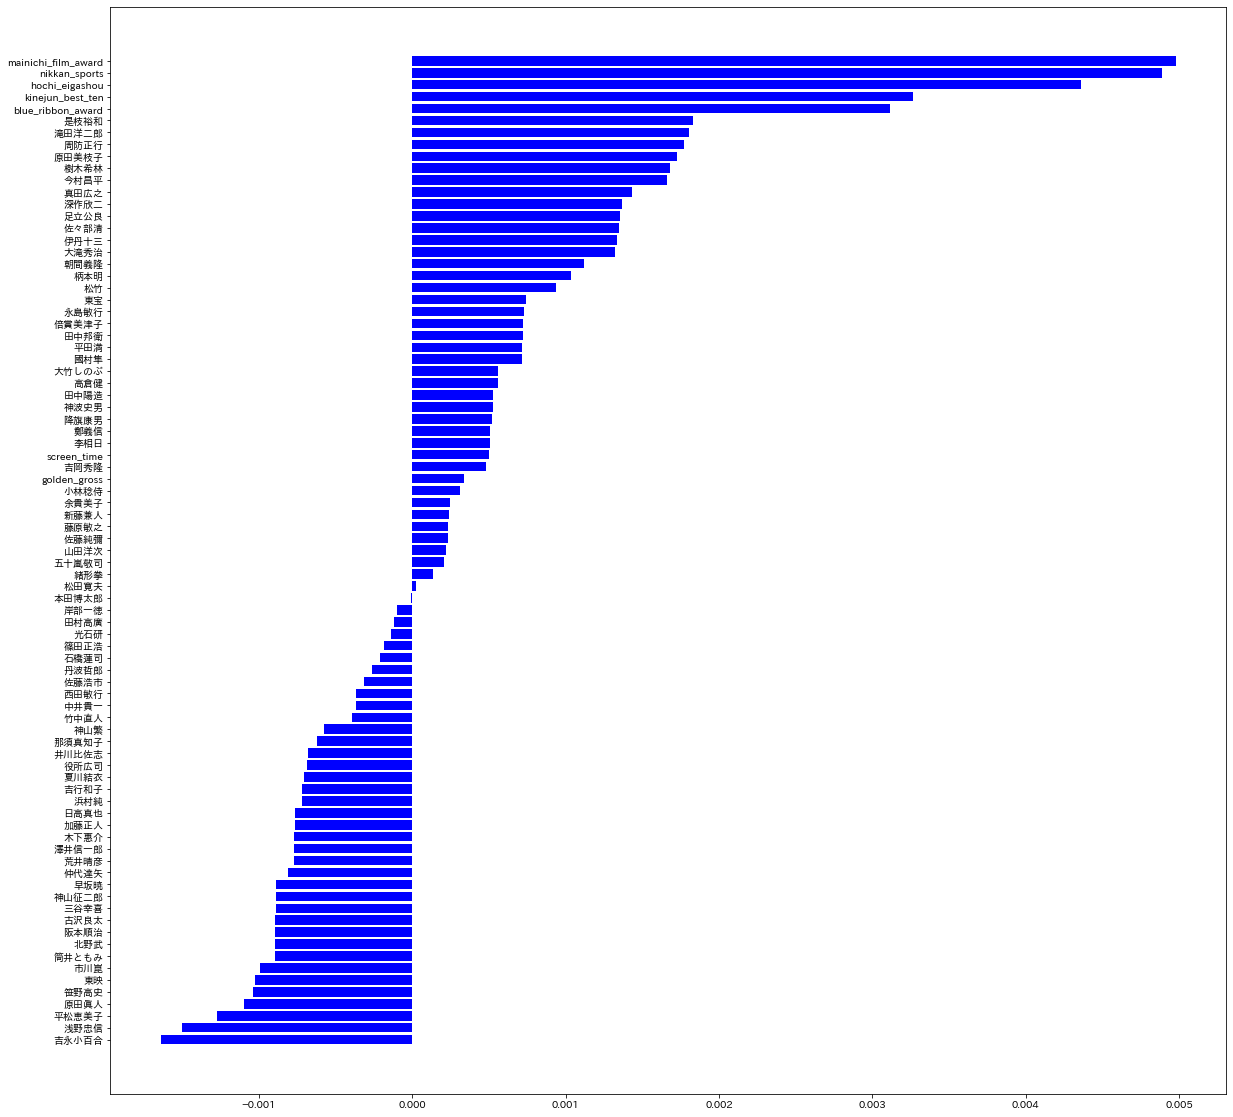

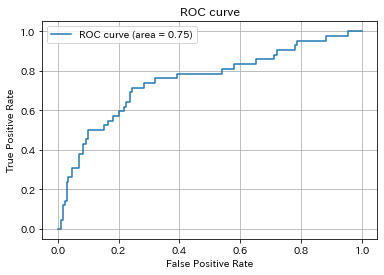

len: 211 , 211
confusion_matrix: 
[[117.  52.]
 [ 11.  31.]]
AUC: 
0.7503522118906735



In [43]:
if __name__ == "__main__":
    train()

In [ ]:
len: 211 , 211
confusion_matrix: 
[[104.  65.]
 [ 10.  32.]]
AUC: 
0.7686672302056917